In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow
import numpy as np
import seaborn as sns
import statsmodels.api as sm

In [40]:
ana_sales = pd.read_parquet('ana_sales_data.parquet', engine='pyarrow')
cig_sales = pd.read_parquet('cig_sales_data.parquet', engine='pyarrow')
beer_sales = pd.read_parquet('beer_sales_data.parquet', engine='pyarrow')

In [41]:
ana = pd.read_parquet('ana_upc.parquet', engine='pyarrow')
cig = pd.read_parquet('cig_upc.parquet', engine='pyarrow')
beer = pd.read_parquet('beer_upc.parquet', engine='pyarrow')

In [42]:
demo = pd.read_parquet('demographic_data.parquet', engine='pyarrow')

## EDA

### Посмотрим на данные

In [187]:
demo.isna().sum()

store        0
age60       10
age9        10
educ        10
ethnic      10
income      10
hhlarge     10
workwom     10
hval150     10
sstrdist    22
sstrvol     22
cpdist5     22
cpwvol5     22
dtype: int64

Заменим недостающие данные медианой.

In [43]:
demo = demo.fillna(demo.median())

Есть ли пропуски в продажах?

In [204]:
print(ana_sales.isna().sum())
print()
print(beer_sales.isna().sum())
print()
print(cig_sales.isna().sum())

store    0
upc      0
week     0
move     0
qty      0
price    0
dtype: int64

store    0
upc      0
week     0
move     0
qty      0
price    0
dtype: int64

store    0
upc      0
week     0
move     0
qty      0
price    0
dtype: int64


В sales NaN-ов нет. Посмотрим в целом, как выглядят датасеты

In [33]:
print('--ana--')
print(ana_sales.head())
print('--beer--')
print(beer_sales.head())
print('--cig--')
print(cig_sales.head())

--ana--
   store         upc  week  move  qty  price  sale
0     76  1192603016   306     0    1   0.00  None
1     76  1192603016   307     1    1   2.99  None
2     76  1192603016   308     0    1   0.00  None
3     76  1192603016   309     0    1   0.00  None
4     76  1192603016   310     0    1   0.00  None
--beer--
   store  upc  week  move  qty  price  sale
0      2  294   298    11    1   2.62  None
1      2  294   299     9    1   2.51  None
2      2  294   300     6    1   2.49  None
3      2  294   301     5    1   2.99  None
4      2  294   302     1    1   2.49  None
--cig--
   store  upc  week  move  qty  price  sale
0      8  190   194     0    1   0.00  None
1      8  190   195     2    1  21.51  None
2      8  190   196     0    1   0.00  None
3      8  190   197     0    1   0.00  None
4      8  190   198     0    1   0.00  None


Целевой переменной будет move, sales уберем из данных.

In [44]:
cig_sales = cig_sales.drop(columns=['sale'])
beer_sales = beer_sales.drop(columns=['sale'])
ana_sales = ana_sales.drop(columns=['sale'])

In [119]:
print('--ana--')
print(ana_sales.agg(['max', 'min', 'nunique']))
print('--beer--')
print(beer_sales.agg(['max', 'min', 'nunique']))
print('--cig--')
print(cig_sales.agg(['max', 'min', 'nunique']))

--ana--
         store          upc  week  move  qty    price
max        146  78765150152   399   963    1    23.69
min          2   1192603016     1     0    1     0.00
nunique     93          641   392   172    1  1152.00
--beer--
         store          upc  week  move  qty    price
max        146  79709638102   399   769    2    29.64
min          2          294    91     0    1     0.00
nunique     89          788   302   375    2  1243.00
--cig--
         store         upc  week  move  qty  price
max        146  8640912356   399  3059    1  250.0
min          2         190     1     0    1    0.0
nunique     93         873   398  2060    1  892.0


У нас есть недели 1-399, но у всех товаров меньше уникальных значений недели. Давайте посмотрим, какие недели отсутствуют

In [34]:
print('ana', set(range(1, 400)).difference(set(ana_sales.week)))
print('beer', set(range(1, 400)).difference(set(beer_sales.week)))
print('cig', set(range(1, 400)).difference(set(cig_sales.week)))

ana {262, 263, 264, 265, 219, 284, 285}
beer {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 219, 262, 263, 264, 265, 284, 285}
cig {219}


По мануалу dominicks данные beer начинаются с 91 недели, но почему у датасетов отсутствуют недели 219, 262-265 и 284-285, непонятно. В целом, это лишь небольшая часть данных, и они внесут не слишком большой шум своим отсутствием. Поэтому в рамках кейса не будем углубляться в заполнение таких пропусков, тем более, мы будем делать предсказания для группы товаров, а не для 1 UPC

In [56]:
ana_sales.groupby('upc')[['week', 'store']].nunique().head(10)

,week,store
upc,,
1192603016,66,1
1192662108,86,8
1650001020,392,55
1650001022,264,21
1650004106,338,56
1650004108,264,18
1650004703,364,36
2140649030,90,53
2586600493,60,2


Есть товары как с большой, так и с очень маленькой представленностью и продажами. Посмотрим, есть ли временные пропуски в рамках одного UPC, или данные непрерывны. Это важно для генерации лагов в будущем.

In [7]:
upc_week = pd.DataFrame(ana_sales.groupby(['upc'])['week'].apply(lambda x: sorted(list(set(x)))))

In [174]:
def is_continuous(numbers):
    return all(numbers[i] + 1 == numbers[i + 1] for i in range(len(numbers) - 1))

upc_week['is_continuous'] = upc_week['week'].apply(is_continuous)

def find_missing(numbers):
    full_range = set(range(min(numbers), max(numbers) + 1))
    return sorted(list(full_range - set(numbers)))

upc_week['missing_weeks'] = upc_week['week'].apply(find_missing)

upc_week.missing_weeks

upc
1192603016                                      []
1192662108                                      []
1650001020     [219, 262, 263, 264, 265, 284, 285]
1650001022               [219, 262, 263, 264, 265]
1650004106     [219, 262, 263, 264, 265, 284, 285]
                              ...                 
72815400100                             [284, 285]
72815400250                             [284, 285]
78765130152                             [284, 285]
78765142067                                     []
78765150152                                     []
Name: missing_weeks, Length: 641, dtype: object

Тут уже знакомые нам пропуски, в остальном данные непрерывные.

### Анализ и визуализация

Сначала объединим все данные и добавим праздники, согласно таблице из мануала.

In [59]:
holidays = {
    # Year 1 and 2
    7: 'Halloween', 11: 'Thanksgiving', 15: 'Christmas', 16: 'New-Year', 
    23: 'Presidents Day', 27: 'Easter',
    35: 'Memorial Day',  
    42: '4th of July', 51: 'Labor Day', 
    59: 'Halloween', 63: 'Thanksgiving', 68: 'New-Year', 75: 'Presidents Day',
    81: 'Easter', 
    89: 'Memorial Day',
    95: '4th of July', 103: 'Labor Day',

    # Year 3 
    112: 'Halloween', 116: 'Thanksgiving', 120: 'Christmas', 121: 'New-Year', 
    128: 'Presidents Day', 132: 'Easter', 
    140: 'Memorial Day', 
    147: '4th of July', 155: 'Labor Day', 

    # Year 4 
    164: 'Halloween', 168: 'Thanksgiving', 172: 'Christmas', 173: 'New-Year', 
    180: 'Presidents Day', 184: 'Easter', 
    192: 'Memorial Day', 
    199: '4th of July', 207: 'Labor Day',

    # Year 5 
    216: 'Halloween', 220: 'Thanksgiving', 224: 'Christmas', 225: 'New-Year', 
    232: 'Presidents Day', 236: 'Easter',
    244: 'Memorial Day',
    251: '4th of July', 259: 'Labor Day',

    # Year 6 
    268: 'Halloween', 272: 'Thanksgiving', 276: 'Christmas', 277: 'New-Year', 
    284: 'Presidents Day', 288: 'Easter', 
    296: 'Memorial Day', 
    303: '4th of July', 311: 'Labor Day',

    # Year 7 
    320: 'Halloween', 324: 'Thanksgiving', 328: 'Christmas', 329: 'New-Year', 
    336: 'Presidents Day', 340: 'Easter',
    348: 'Memorial Day', 
    355: '4th of July', 363: 'Labor Day',

    # Year 8 
    372: 'Halloween', 376: 'Thanksgiving', 380: 'Christmas', 381: 'New-Year', 
    388: 'Presidents Day', 392: 'Easter',
    400: 'Memorial Day', 
    407: '4th of July', 415: 'Labor Day',
}


In [46]:
def merge_data(sales, info):
    data = sales.merge(info, on='upc')
    data = data.merge(demo, on='store')
    data['holiday'] = data.week.map(holidays)
    data['holiday'] = data['holiday'].fillna('No holiday')
    return data

In [60]:
ana_data = merge_data(ana_sales, ana)
beer_data = merge_data(beer_sales, beer)
cig_data = merge_data(cig_sales, cig)

##### Beer

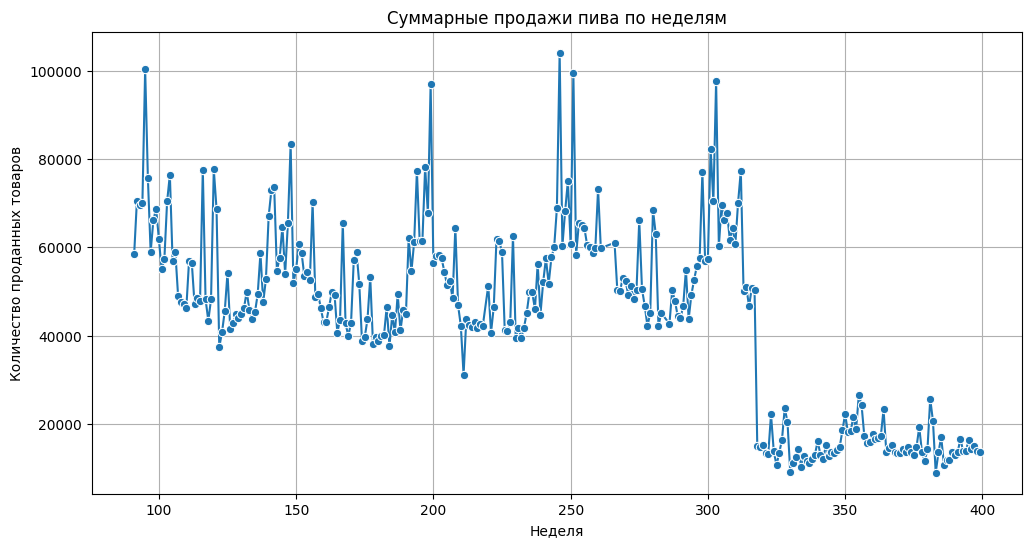

In [61]:
beer_weekly = beer_data.groupby('week')['move'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=beer_weekly, x='week', y='move', marker='o')
plt.title('Суммарные продажи пива по неделям')
plt.xlabel('Неделя')
plt.ylabel('Количество проданных товаров')
plt.grid(True)
plt.show()

Продажи пива резко падают на 318 неделе. Это может быть узким горлышком при использовании стат. моделей, так как датасет нужно будет разбивать на train и test последовательно, и при этом модель будет обучаться на данных, непохожих на тест. Для пива будет лучше использовать бустинг.

Введем в этот датасет фичу, которая будет указывать на период - до или после 318

In [62]:
beer_data['after_318'] = (beer_data.week >= 318)

Посмотрим, например, как влияют праздники на продажу пива, в разрезе одного года

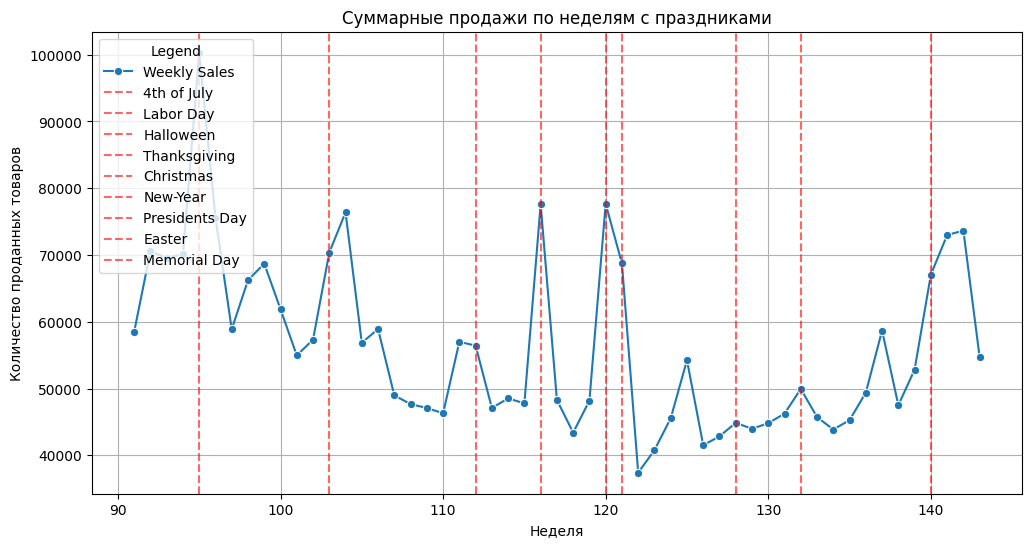

In [63]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=beer_data[beer_data['week'] < (91+53)].groupby('week')['move'].sum().reset_index(), x='week', y='move', marker='o', label='Weekly Sales')

for week, holiday in holidays.items():
    if week > 90 and week < (91 + 53):
        plt.axvline(x=week, color='red', linestyle='--', alpha=0.6, label=holiday)

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), title="Legend", loc="upper left")

plt.title('Суммарные продажи по неделям с праздниками')
plt.xlabel('Неделя')
plt.ylabel('Количество проданных товаров')
plt.grid(True)
plt.show()

Видно пики продаж, причем только для определенных праздников - НГ, Рождество, 4-е июля.

##### Cigarettes

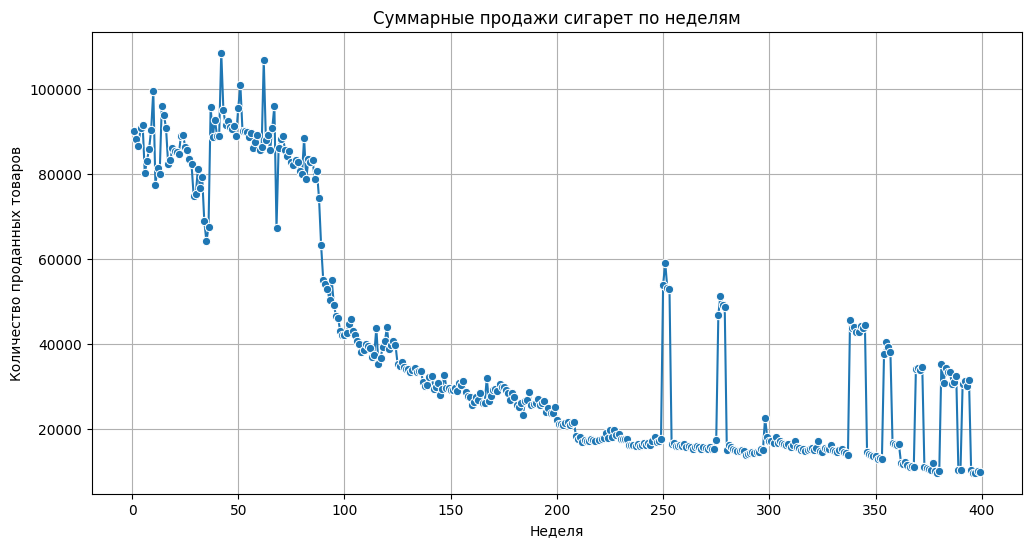

In [64]:
cig_weekly = cig_data.groupby('week')['move'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=cig_weekly, x='week', y='move', marker='o')
plt.title('Суммарные продажи сигарет по неделям')
plt.xlabel('Неделя')
plt.ylabel('Количество проданных товаров')
plt.grid(True)
plt.show()

У сигарет четко виден отрицательный тренд, и вид данных также меняется со временем.

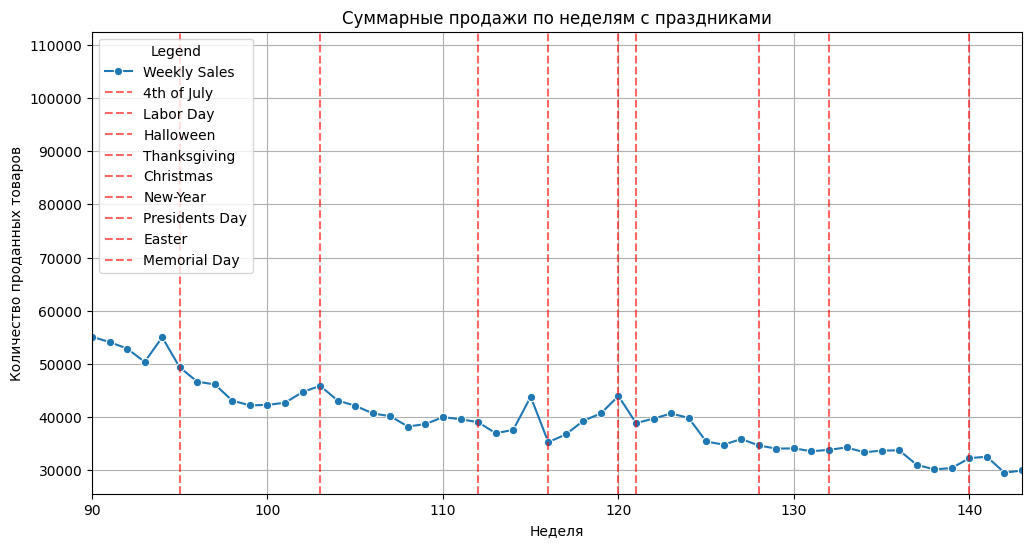

In [65]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=cig_data[cig_data['week'] < (91+53)].groupby('week')['move'].sum().reset_index(), x='week', y='move', marker='o', label='Weekly Sales')

for week, holiday in holidays.items():
    if (week > 90) and (week < (91 + 53)):
        plt.axvline(x=week, color='red', linestyle='--', alpha=0.6, label=holiday)

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), title="Legend", loc="upper left")

plt.title('Суммарные продажи по неделям с праздниками')
plt.xlabel('Неделя')
plt.xlim(90,143)
plt.ylabel('Количество проданных товаров')
plt.grid(True)
plt.show()

##### Analgetics

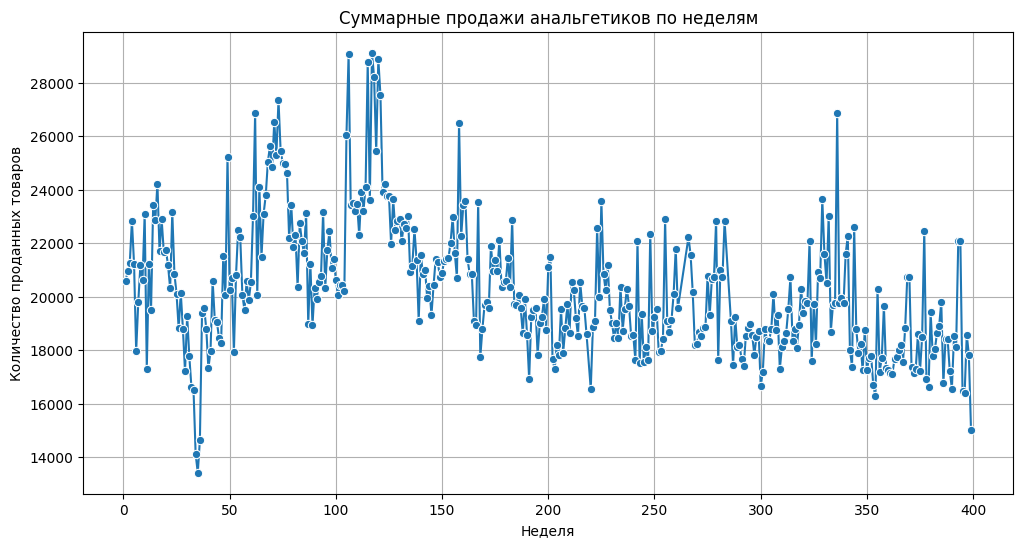

In [68]:
ana_weekly = ana_data.groupby('week')['move'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=ana_weekly, x='week', y='move', marker='o')
plt.title('Суммарные продажи анальгетиков по неделям')
plt.xlabel('Неделя')
plt.ylabel('Количество проданных товаров')
plt.grid(True)
plt.show()

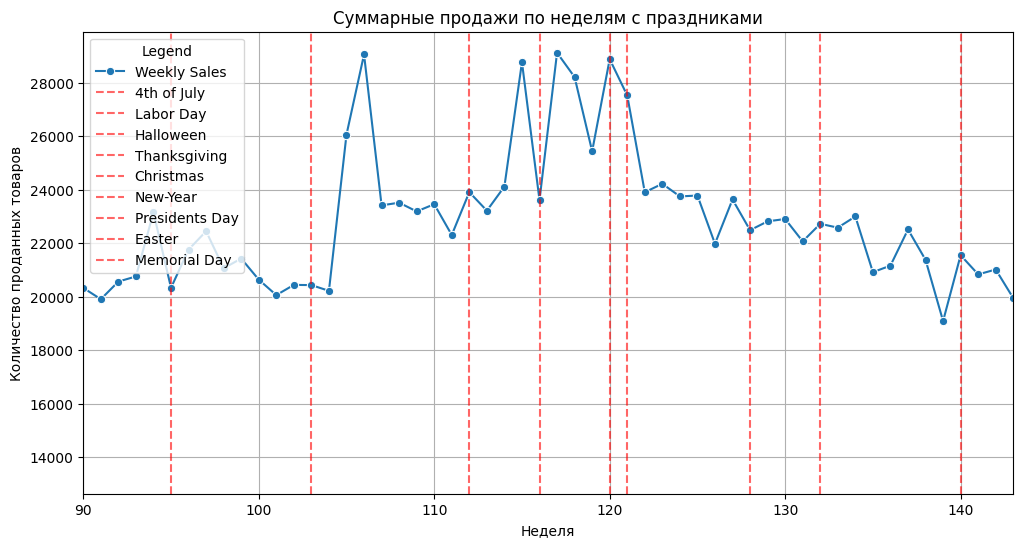

In [66]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=ana_data[ana_data['week'] < (91+53)].groupby('week')['move'].sum().reset_index(), x='week', y='move', marker='o', label='Weekly Sales')

for week, holiday in holidays.items():
    if (week > 90) and (week < (91 + 53)):
        plt.axvline(x=week, color='red', linestyle='--', alpha=0.6, label=holiday)

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), title="Legend", loc="upper left")

plt.title('Суммарные продажи по неделям с праздниками')
plt.xlabel('Неделя')
plt.xlim(90,143)
plt.ylabel('Количество проданных товаров')
plt.grid(True)
plt.show()

###### Seasonality decomposition example

Разложим ряд на сезонность, тренд и остатки на примере датасета анальгетиков

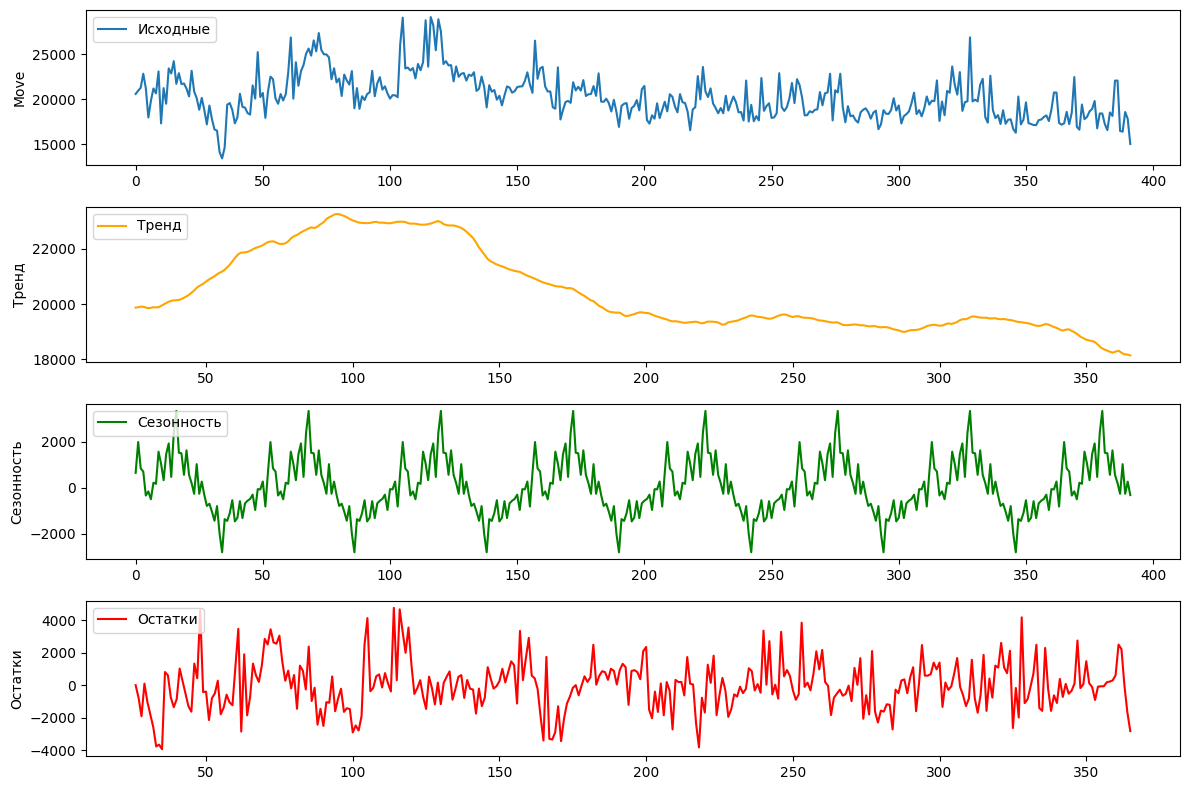

In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ana_weekly['move'], model='additive', period=52)

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(ana_weekly['move'], label='Исходные')
plt.legend(loc='upper left')
plt.ylabel('Move')

plt.subplot(412)
plt.plot(result.trend, label='Тренд', color='orange')
plt.legend(loc='upper left')
plt.ylabel('Тренд')

plt.subplot(413)
plt.plot(result.seasonal, label='Сезонность', color='green')
plt.legend(loc='upper left')
plt.ylabel('Сезонность')

plt.subplot(414)
plt.plot(result.resid, label='Остатки', color='red')
plt.legend(loc='upper left')
plt.ylabel('Остатки')

plt.tight_layout()
plt.show()


Здесь видна годичная (~50 недель) сезонность

##### Demographics correlations

Посмотрим на данные на уровне магазинов, чтобы узнать, есть ли явная корреляция демографических признаков с суммарными продажами в магазинах.

In [73]:
demo['ana_sales'] = demo.store.map(dict(ana_data.groupby('store')['move'].sum()))
demo['cig_sales'] = demo.store.map(dict(cig_data.groupby('store')['move'].sum()))
demo['beer_sales'] = demo.store.map(dict(beer_data.groupby('store')['move'].sum()))

In [76]:
demo_cleaned = demo.dropna()
sales_columns = ['ana_sales', 'cig_sales', 'beer_sales']
features = ['store', 'age60', 'age9', 'educ', 'ethnic', 'income', 
            'hhlarge', 'workwom', 'hval150', 'sstrdist', 'sstrvol', 'cpdist5', 'cpwvol5']

<Figure size 1500x1000 with 0 Axes>

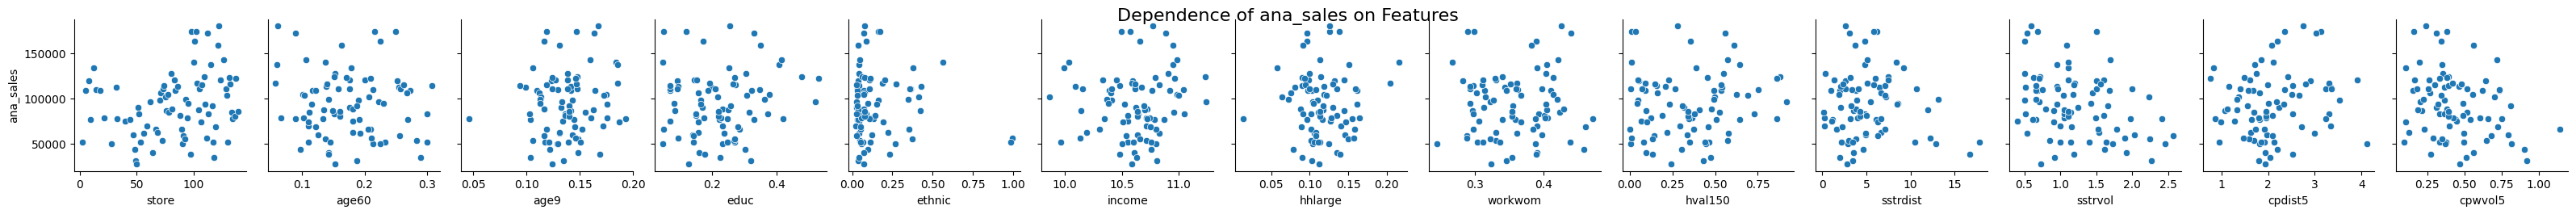

<Figure size 1500x1000 with 0 Axes>

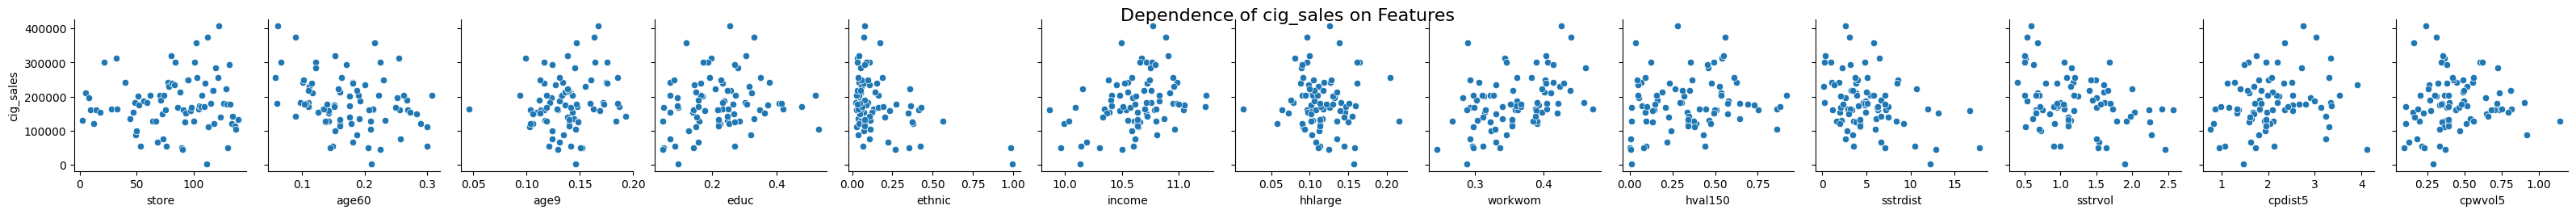

<Figure size 1500x1000 with 0 Axes>

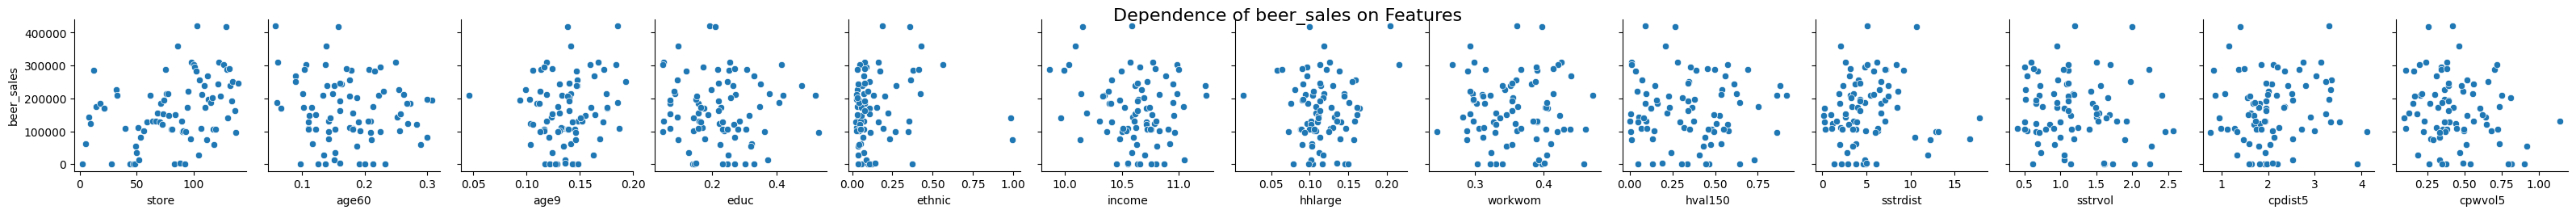

In [280]:
for sale_col in sales_columns:
    plt.figure(figsize=(15, 10))
    sns.pairplot(data=demo_cleaned, 
                 y_vars=sale_col, 
                 x_vars=features, 
                 kind="scatter",
                 height=2.5)
    plt.suptitle(f'Dependence of {sale_col} on Features', y=1.02, fontsize=16)
    plt.show()

Визуально явных корреляций суммарных продаж с признаками магазинов не наблюдается, но лучше проверим heatmap-ом

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 [Text(0.5, 0, 'store'),
  Text(1.5, 0, 'age60'),
  Text(2.5, 0, 'age9'),
  Text(3.5, 0, 'educ'),
  Text(4.5, 0, 'ethnic'),
  Text(5.5, 0, 'income'),
  Text(6.5, 0, 'hhlarge'),
  Text(7.5, 0, 'workwom'),
  Text(8.5, 0, 'hval150'),
  Text(9.5, 0, 'sstrdist'),
  Text(10.5, 0, 'sstrvol'),
  Text(11.5, 0, 'cpdist5'),
  Text(12.5, 0, 'cpwvol5'),
  Text(13.5, 0, 'ana_sales'),
  Text(14.5, 0, 'cig_sales'),
  Text(15.5, 0, 'beer_sales')])

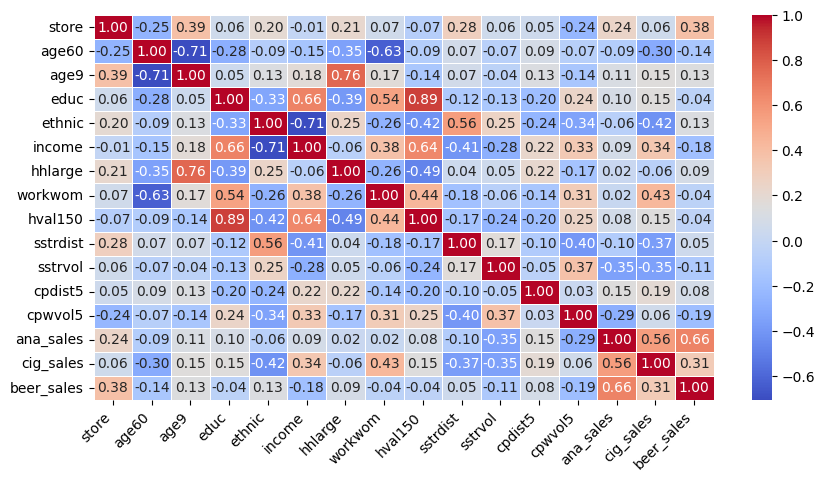

In [79]:
correlation_matrix = demo_cleaned.corr()

plt.figure(figsize=(10, 5))  
sns.heatmap(correlation_matrix, 
            annot=True,        
            cmap="coolwarm",   
            fmt=".2f",         
            cbar=True,         
            linewidths=0.5)    

plt.xticks(rotation=45, ha='right') 

Корреляций между продажами и признаками, которые были бы хотя бы выше 0.5, нет.

Посмотрим также, как суммарные продажи разных категорий могут зависеть друг от друга:

Для пива и анальгетиков линейной корреляции нет

In [20]:
beer_ana = beer_weekly.merge(ana_weekly, on='week', how='inner')
beer_ana.drop(columns=['week']).corr()

,move_x,move_y
move_x,1.000000,0.207642
move_y,0.207642,1.000000


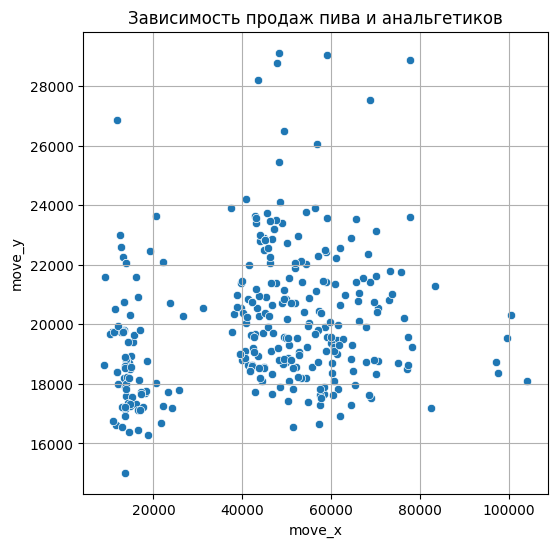

In [336]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=beer_ana, x='move_x', y='move_y', marker='o')
plt.title('Зависимость продаж пива и анальгетиков')
plt.grid(True)
plt.show()

In [339]:
cig_ana = cig_weekly.merge(ana_weekly, on='week', how='inner')
cig_ana.drop(columns=['week']).corr()

,move_x,move_y
move_x,1.00000,0.31942
move_y,0.31942,1.00000


Несколько сильнее выражена зависимость продаж сигарет и анальгетиков, но все равно линейная корреляция очень мала.

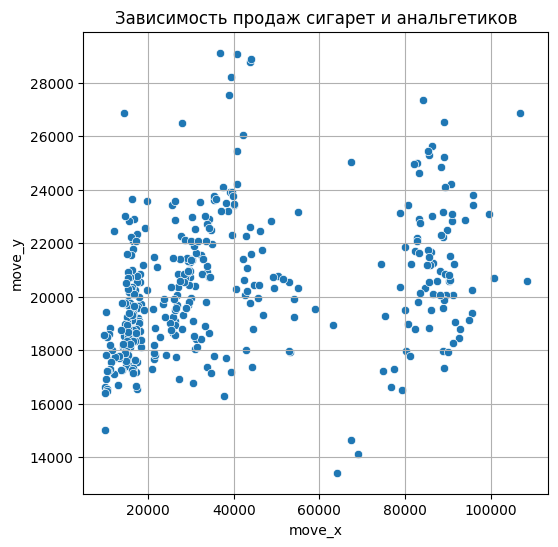

In [340]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=cig_ana, x='move_x', y='move_y', marker='o')
plt.title('Зависимость продаж сигарет и анальгетиков')
plt.grid(True)
plt.show()

In [341]:
cig_beer = cig_weekly.merge(beer_weekly, on='week', how='inner')
cig_beer.drop(columns=['week']).corr()

,move_x,move_y
move_x,1.0000,0.2316
move_y,0.2316,1.0000


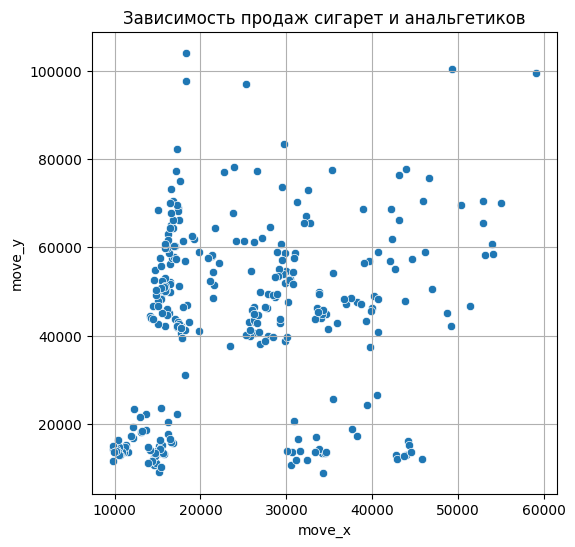

In [342]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=cig_beer, x='move_x', y='move_y', marker='o')
plt.title('Зависимость продаж сигарет и анальгетиков')
plt.grid(True)
plt.show()

Опять же, четко выраженных зависимостей не наблюдаем

### Эластичность спроса по цене

Будем сначала анализировать на уровне 1 товара в 1 магазине, для этого понадобится сгруппировать данные. После этого возьмем медиану в качестве статистики.

In [21]:
def elast_calc(dataframe):  
    data = dataframe[dataframe['price'] > 0][['week', 'upc', 'store', 'price', 'move']].dropna()
    elasticity_results = []
    grouped = data.groupby(['store', 'upc'])

    for (store, upc), group in grouped:
        group = group.sort_values('week')
        
        group['delta_q'] = group['move'].diff()
        group['delta_p'] = group['price'].diff()
        group['percent_change_q'] = group['delta_q'] / group['move'].shift(1)
        group['percent_change_p'] = group['delta_p'] / group['price'].shift(1)
        group['elasticity'] = group['percent_change_q'] / group['percent_change_p']
        
        valid_elasticities = group['elasticity'].replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(valid_elasticities) > 0:
            mean_elasticity = valid_elasticities.mean()
            elasticity_results.append({'store': store, 'upc': upc, 'elasticity': mean_elasticity})

    return pd.DataFrame(elasticity_results)

In [ ]:
beer_elast = elast_calc(beer_data)
ana_elast = elast_calc(ana_data)
cig_elast = elast_calc(cig_data)

c:\Users\bezpa\Anaconda_Navigator\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


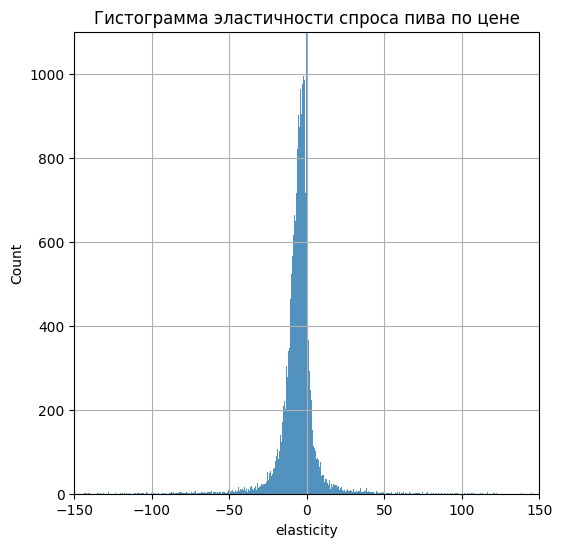

Медианная эластичноть спроса по цене, пиво -4.450306586270872


In [408]:
plt.figure(figsize=(6, 6))
sns.histplot(beer_elast.elasticity)
plt.title('Гистограмма эластичности спроса пива по цене')
plt.xlim(-150,150)
plt.ylim(0,1100)
plt.grid(True)
plt.show()
print('Медианная эластичность спроса по цене, пиво', beer_elast.elasticity.median())

Спрос на пиво очень эластичен по цене

c:\Users\bezpa\Anaconda_Navigator\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


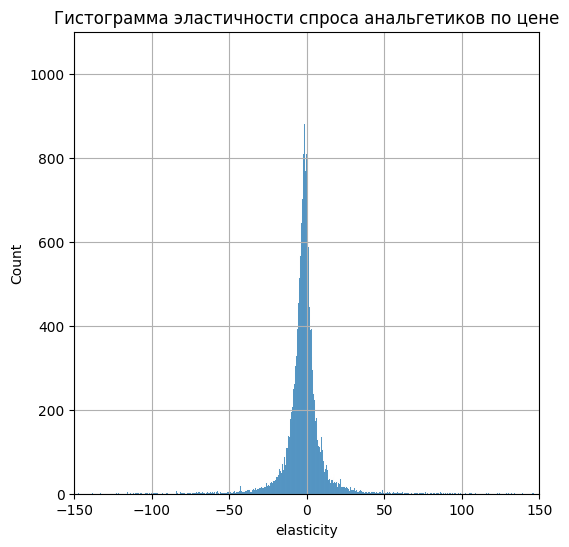

Медианная эластичноть спроса по цене, анальгетики -0.7030447330447313


In [407]:
plt.figure(figsize=(6, 6))
sns.histplot(ana_elast.elasticity)
plt.title('Гистограмма эластичности спроса анальгетиков по цене')
plt.xlim(-150,150)
plt.ylim(0,1100)
plt.grid(True)
plt.show()
print('Медианная эластичность спроса по цене, анальгетики', ana_elast.elasticity.median())

Здесь при повышении цены спрос падает не так сильно, как на пиво, и переходит в категорию неэластичного (>-1)

c:\Users\bezpa\Anaconda_Navigator\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


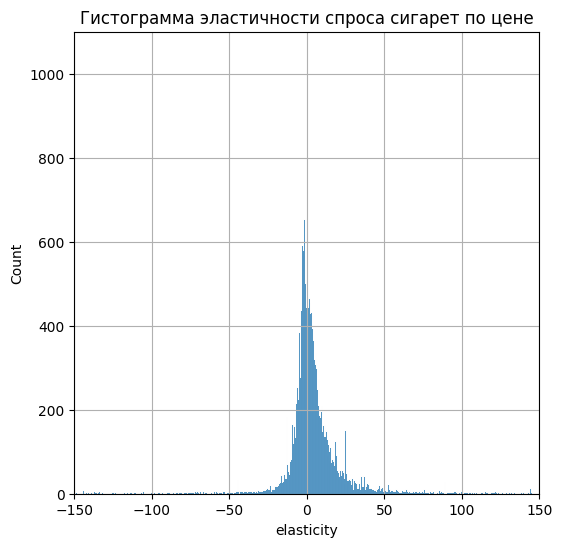

Медианная эластичноть спроса по цене, сигареты 0.0


In [ ]:
plt.figure(figsize=(6, 6))
sns.histplot(cig_elast.elasticity)
plt.title('Гистограмма эластичности спроса сигарет по цене')
plt.xlim(-150,150)
plt.ylim(0,1100)
plt.grid(True)
plt.show()
print('Медианная эластичность спроса по цене, сигареты', cig_elast.elasticity.median())

🤔 идеально неэластичный спрос на сигареты

## ML part

### Boosting

#### Feature engineering

В ML-части начнем с бустинговой модели, для нее понадобятся lag и rolling-фичи. Бустинги удобны тем, что могут работать с несколькими переменными, в том числе категориальными. Для них не нужно агрегировать данные, как для статистических моделей, но нужно сгенерировать признаки, в которых будут содержаться временные данные. После этого с данными можно работать, как с табличными.
Лаги, которые мы выберем, зависят от горизонта предсказаний. Например, если мы хотим делать предсказание на след. неделю, то мы можем взять минимальный лаг 1. Если на месяц вперед - то минимальный лаг должен быть 4 (недели), чтобы не было утечки.

Рассмотрим здесь случай предсказания на следующую неделю.
Возьмем лаги 1, 2, 3, 4, 5, 6, 13, 26 недели и окна в 2, 4, 6 недели. Сделаем эту часть на примере анальгетиков, для других датасетов логика аналогичная.

In [80]:
columns_to_drop = ['qty', 'com_code', 'descrip', 'case']

In [81]:
ana_data_copy = ana_data.sort_values('week').drop(columns = columns_to_drop)
beer_data_copy = beer_data.sort_values('week').drop(columns = columns_to_drop)

В колонке цена указан 0 в дни, когда нет продаж. Это создаст нам утечку данных, поэтому заменим такие значения

In [138]:
ana_data_copy['price'] = ana_data_copy.price.astype(str).replace('0.0', 'NaN').astype(float).interpolate()
beer_data_copy['price'] = beer_data_copy.price.astype(str).replace('0.0', 'NaN').astype(float).interpolate()

In [83]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe[f'move_lag_{lag}'] = dataframe.groupby(['store', 'upc'])['move'].transform(
            lambda x: x.shift(lag))
    return dataframe

def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe[f'move_roll_mean_{window}'] = dataframe.groupby(['store', 'upc'])['move'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()) 
    return dataframe

def apply_feature_engineering(data, lags=[1, 2, 3, 4, 5, 6, 13, 26], windows=[2, 4, 6]):
    data = lag_features(data, lags)
    data = roll_mean_features(data, windows)
    return data

In [84]:
ana_data_lagged = apply_feature_engineering(ana_data_copy)
beer_data_lagged = apply_feature_engineering(beer_data_copy)

Проверим, все ли ок с данными на примере одного товара и магазина:

In [85]:
ana_data_lagged[(ana_data_lagged.upc == 3828161077) & (ana_data_lagged.store == 136)]

,store,upc,week,move,price,size,nitem,age60,age9,educ,...,move_lag_2,move_lag_3,move_lag_4,move_lag_5,move_lag_6,move_lag_13,move_lag_26,move_roll_mean_2,move_roll_mean_4,move_roll_mean_6
633889,136,3828161077,73,0,1.890000,500 CT,6100151,0.160414,0.139877,0.220789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
633890,136,3828161077,74,0,2.850000,500 CT,6100151,0.160414,0.139877,0.220789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.000000
633891,136,3828161077,75,0,2.556667,500 CT,6100151,0.160414,0.139877,0.220789,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.000000
633892,136,3828161077,76,0,5.256667,500 CT,6100151,0.160414,0.139877,0.220789,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.000000
633893,136,3828161077,77,0,5.123333,500 CT,6100151,0.160414,0.139877,0.220789,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634203,136,3828161077,395,4,6.190000,500 CT,6100151,0.160414,0.139877,0.220789,...,5.0,1.0,2.0,2.0,3.0,3.0,2.0,5.0,3.25,3.000000
634204,136,3828161077,396,7,6.190000,500 CT,6100151,0.160414,0.139877,0.220789,...,5.0,5.0,1.0,2.0,2.0,2.0,2.0,4.5,3.75,3.166667
634205,136,3828161077,397,2,6.190000,500 CT,6100151,0.160414,0.139877,0.220789,...,4.0,5.0,5.0,1.0,2.0,2.0,3.0,5.5,5.25,4.000000
634206,136,3828161077,398,2,6.190000,500 CT,6100151,0.160414,0.139877,0.220789,...,7.0,4.0,5.0,5.0,1.0,1.0,3.0,4.5,4.50,4.000000


Много NaN-ов в колонке с большим лагом, но LGBM справляется с NaN-ами.

У нас есть категориальные фичи, лаги, которые несут информацию о предыдущих продажах, и некоторые числовые признаки, например, цена. Так как все нужные нам "временные" данные уже присутствуют в лагах, мы берем move в качестве целевой переменной и можем разбить датасет на train и val в любом порядке (но здесь возьмем две последовательные части для удобства). В качестве метрики возьмем WMAPE.

In [86]:
from sklearn.preprocessing import LabelEncoder

In [87]:
ana_data_lagged['size'] = LabelEncoder().fit_transform(ana_data_lagged['size'])
ana_data_lagged['holiday'] = LabelEncoder().fit_transform(ana_data_lagged['holiday'])
beer_data_lagged['size'] = LabelEncoder().fit_transform(beer_data_lagged['size'])
beer_data_lagged['holiday'] = LabelEncoder().fit_transform(beer_data_lagged['holiday'])

#### Training

##### Analgetics

In [142]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

target = 'move'

categorical_cols = ['store', 'size', 'holiday']
for col in categorical_cols:
    ana_data_lagged[col] = ana_data_lagged[col].astype('category')

X = ana_data_lagged.drop(columns=['week', 'upc', 'move'])
y = ana_data_lagged[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_cols, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000
)

y_pred = model.predict(X_val, num_iteration=model.best_iteration)

In [145]:
model.save_model('lgbm_model_ana.txt')

В качестве бейзлайна будем использовать среднее. WMAPE бейзлайна: 

In [146]:
def wmape(y_true, y_pred):
    return 100 * np.sum(np.abs(y_pred - y_true)) / np.sum(np.abs(y_true))

wmape(y_val, np.round([np.mean(y_val)] * len(y_val)))

130.27245052783172

Округлим предсказания, т.к. целевая переменная  - int, и посчитаем WMAPE нашей модели:

In [147]:
rounded_y_pred = np.round(y_pred).astype(int)
wmape(y_val, rounded_y_pred)

65.97574931529748

Метрика намного лучше, чем у бейзлайна, но ошибка довольно большая. Посмотрим на график истинных значений и предсказаний на примере 1 продукта из 1 магазина: 

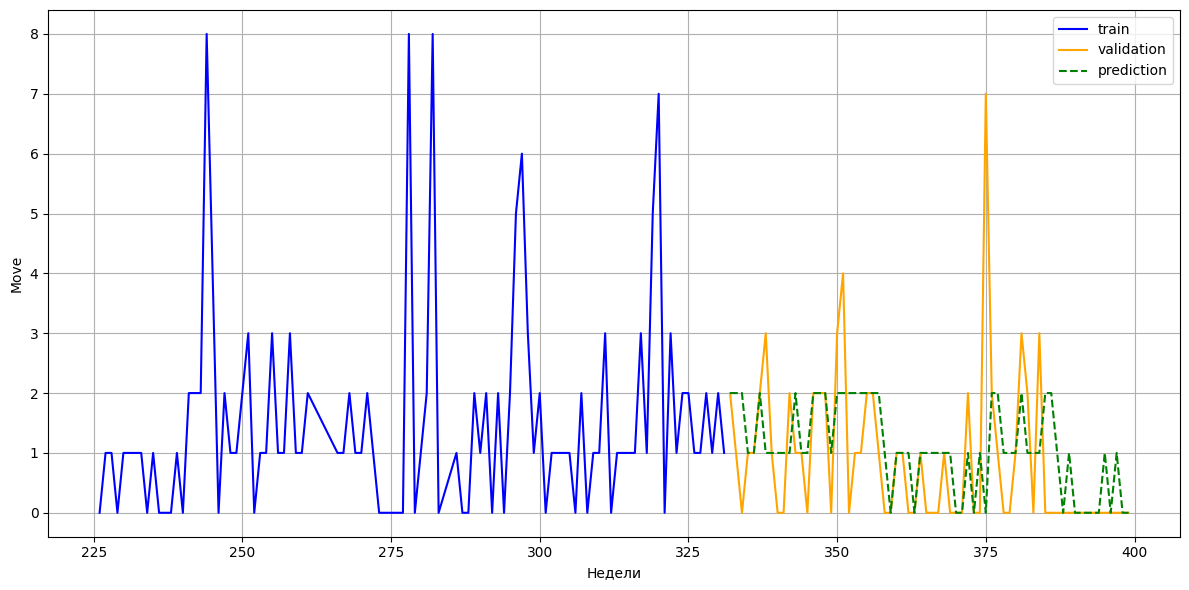

In [93]:
X_train['week'] = ana_data_lagged.week.iloc[:len(X_train)]
X_train['upc'] = ana_data_lagged.upc.iloc[:len(X_train)]
X_train['true'] = y_train

X_val['week'] = ana_data_lagged.week.iloc[len(X_train):]
X_val['upc'] = ana_data_lagged.upc.iloc[len(X_train):]
X_val['prediction'] = rounded_y_pred
X_val['true'] = y_val
train_data_example = X_train[(X_train.store == 71) & (X_train.upc == 31981000893)][-100:]
val_data_example = X_val[(X_val.store == 71) & (X_val.upc == 31981000893)]

weeks_train = ana_data_lagged['week'].iloc[:len(X_train)]
weeks_val = ana_data_lagged['week'].iloc[len(X_train):]   

plt.figure(figsize=(12, 6))

plt.plot(train_data_example.week, train_data_example.true, label='train', color='blue')

plt.plot(val_data_example.week, val_data_example.true, label='validation', color='orange')

plt.plot(val_data_example.week, val_data_example.prediction, label='prediction', color='green', linestyle='--')

plt.xlabel('Недели')
plt.ylabel('Move')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


Предсказание не слишком точное, его можно было бы улучшить 1) дополнительными признаками, например, большим кол-вом лагов, ввести времена года и т.д. 2) подбором гиперпараметров с optuna. 

Чтобы узнать, какие признаки имеют наибольшее "значение" для модели, воспользуемся feature importance

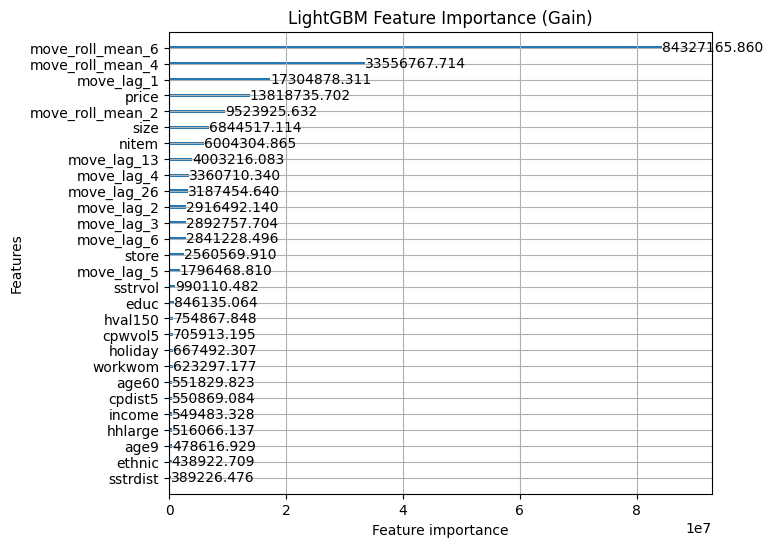

In [94]:
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

Довольно интересно, что наибольшую важность имеет не лаг в 1 неделю, как это часто бывает, а rolling mean за 1,5 месяца. Не совсем очевидно, как это интерпретировать. Можно предположить, что модель в своих предсказаний в первую очередь смотрит на 1,5-месячный тренд. 

##### Beer

Для пива лучше попробовать бустинг, т.к. после 318-й недели продажи резко падают, и любой модели, которая работает с данными как с последовательностью, будет сложно построить предсказания. Мы также ввели специальную переменную, которая будет указывать на этот период. 

In [149]:
beer_data['after_318'] = beer_data.after_318.astype('int')

In [150]:
for col in categorical_cols:
    beer_data_lagged[col] = beer_data_lagged[col].astype('category')

X = beer_data_lagged.drop(columns=['week', 'upc', 'move'])
y = beer_data_lagged[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_cols, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000
)

y_pred = model.predict(X_val, num_iteration=model.best_iteration)

In [ ]:
model.save_model('lgbm_model_beer.txt')

WMAPE бейзлайна: 

In [151]:
def wmape(y_true, y_pred):
    return 100 * np.sum(np.abs(y_pred - y_true)) / np.sum(np.abs(y_true))

wmape(y_val, np.round([np.mean(y_val)] * len(y_val)))

126.10856243754377

WMAPE нашей модели:

In [152]:
rounded_y_pred = np.round(y_pred).astype(int)
wmape(y_val, rounded_y_pred)

61.391264177603986

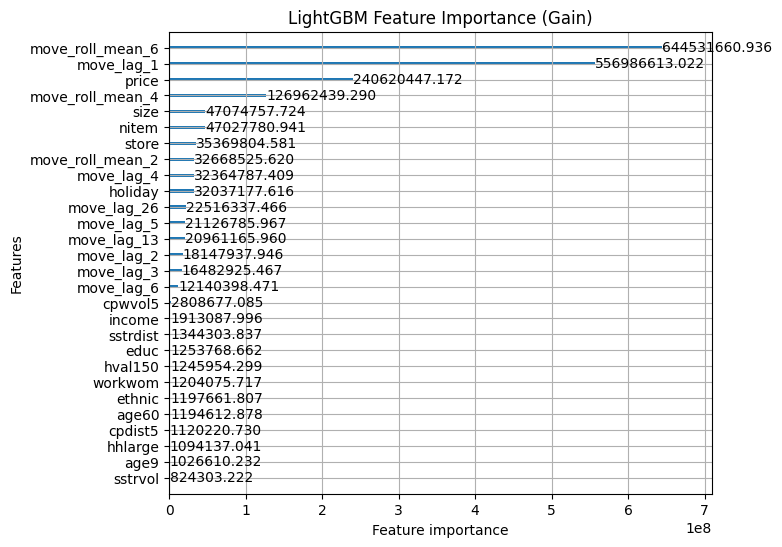

In [153]:
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

У пива, в отличие от анальгетиков, лаг 1 является вторым по важности признаком, то есть модель смотрит на продажи предыдущей недели. Такая разница в feature importance для лекарств и пива, в целом, логична.

In [162]:
beer_data_lagged.sample(20)

,store,upc,week,move,price,size,nitem,age60,age9,educ,...,move_lag_2,move_lag_3,move_lag_4,move_lag_5,move_lag_6,move_lag_13,move_lag_26,move_roll_mean_2,move_roll_mean_4,move_roll_mean_6
3714242,133,8797501350,344,0,7.323333,32,9412720,0.160414,0.139877,0.220789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000
3512310,126,8417332130,105,0,3.590000,32,9401750,0.107002,0.160060,0.413222,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.00,0.000000
3634145,102,8769211216,258,2,1.990000,11,9490420,0.216626,0.146946,0.120658,...,1.0,4.0,0.0,2.0,2.0,NaN,NaN,1.5,1.75,1.833333
3907343,130,79709634767,365,0,6.365000,32,9490540,0.145117,0.150929,0.143407,...,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.5,0.25,0.333333
2206772,105,7204001151,214,0,4.865000,39,9406000,0.175542,0.147565,0.094236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000
3104473,73,8066095603,354,0,7.990000,12,9490580,0.257451,0.124465,0.073054,...,0.0,0.0,0.0,0.0,0.0,3.0,NaN,0.0,0.00,0.000000
3340112,77,8378357521,371,1,5.990000,32,9437310,0.101100,0.174717,0.376871,...,0.0,0.0,0.0,1.0,0.0,1.0,NaN,0.0,0.00,0.166667
1128775,78,3410017602,167,11,7.390000,2,9450300,0.111948,0.155391,0.314432,...,6.0,6.0,3.0,6.0,8.0,14.0,24.0,8.0,6.25,6.500000
2241005,102,7204031310,251,0,6.623333,15,9405200,0.216626,0.146946,0.120658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000
2937538,128,7336068741,110,1,6.790000,2,9407850,0.157485,0.138209,0.211897,...,1.0,0.0,1.0,0.0,1.0,1.0,NaN,0.5,0.50,0.500000


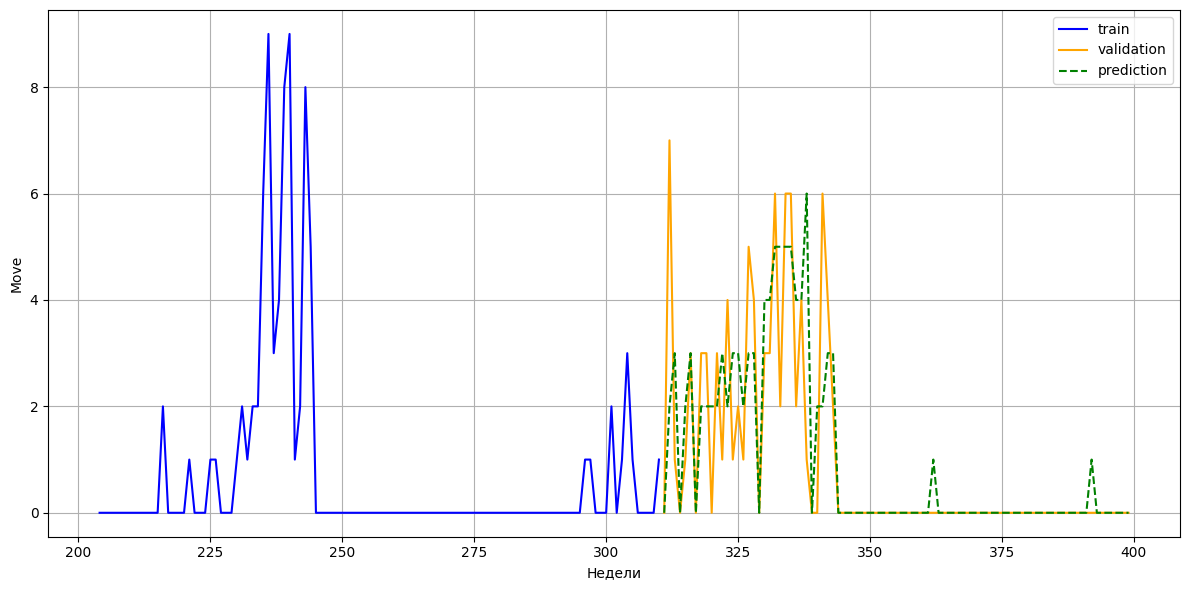

In [165]:
X_train['week'] = beer_data_lagged.week.iloc[:len(X_train)]
X_train['upc'] = beer_data_lagged.upc.iloc[:len(X_train)]
X_train['true'] = y_train

X_val['week'] = beer_data_lagged.week.iloc[len(X_train):]
X_val['upc'] = beer_data_lagged.upc.iloc[len(X_train):]
X_val['prediction'] = rounded_y_pred
X_val['true'] = y_val
train_data_example = X_train[(X_train.store == 21) & (X_train.upc == 8797502650)][-100:]
val_data_example = X_val[(X_val.store == 21) & (X_val.upc == 8797502650)]

weeks_train = beer_data_lagged['week'].iloc[:len(X_train)][-100:]
weeks_val = beer_data_lagged['week'].iloc[len(X_train):]   

plt.figure(figsize=(12, 6))

plt.plot(train_data_example.week, train_data_example.true, label='train', color='blue')

plt.plot(val_data_example.week, val_data_example.true, label='validation', color='orange')

plt.plot(val_data_example.week, val_data_example.prediction, label='prediction', color='green', linestyle='--')

plt.xlabel('Недели')
plt.ylabel('Move')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


### ARIMAX

Теперь построим прогноз с помощью классической модели. Мы используем ее вариант, который работает с несколькими признаками. В этом случае при разбиении датасета нужно учитывать последовательность данных. 

##### Analgetics

Возьмем суммарные продажи анальгетиков за неделю и усредненные остальные признаки.

In [95]:
def preprocess(dataframe):
    dataframe_copy = dataframe.copy()
    dataframe_copy = pd.concat([dataframe_copy, pd.get_dummies(dataframe_copy['holiday']).astype('int')], axis=1)
    means = dataframe_copy[['week', 'price', 'case', 'nitem', 'age60', 'age9', 'educ', 'ethnic', 'income',
        'hhlarge', 'workwom', 'hval150', 'sstrdist', 'sstrvol', 'cpdist5','cpwvol5',
        '4th of July', 'Christmas', 'Easter', 'Halloween',
        'Labor Day', 'Memorial Day', 'New-Year', 'No holiday', 'Presidents Day',
        'Thanksgiving']].groupby('week').mean()
    move_sum = dataframe_copy.groupby('week')['move'].sum()
    data = pd.concat([move_sum, means], axis=1)
    return data

In [225]:
data = preprocess(ana_data)

Чтобы определить p и q для модели, посмотрим на функции автокорреляции

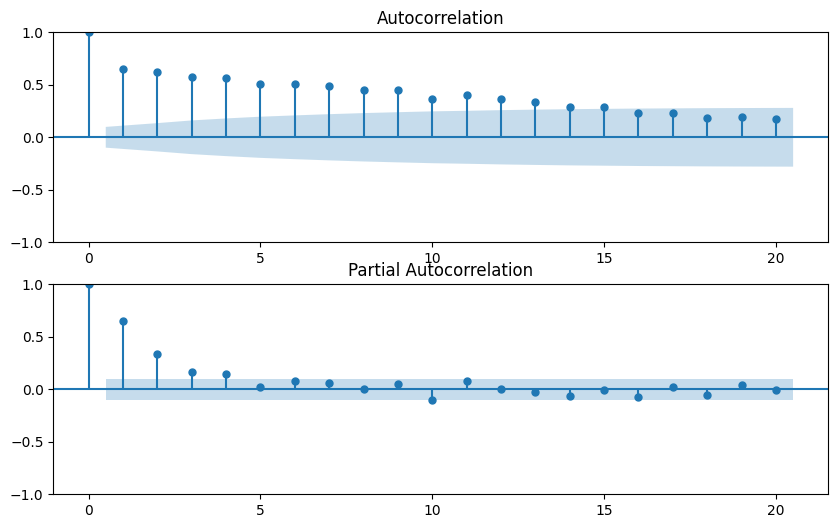

In [100]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ana_weekly.move.values.squeeze(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ana_weekly.move, lags=20, ax=ax2)
plt.show()

Попробуем взять p, равным 5, а q - 13, т.к. это последние значения ACF и PACF, стат. значимо отличные от нуля

Теперь нужно узнать параметр d, т.е. сколько раз нужно дифференцировать ряд до стационарного

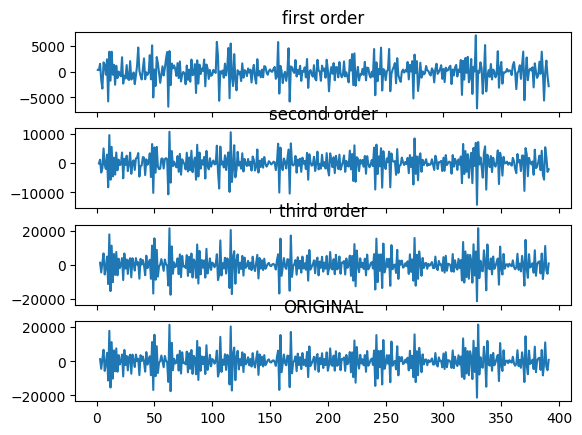

Test statistic   -8.077705e+00
p-value           1.490017e-12
used_lag          9.000000e+00
NOBS              3.810000e+02
dtype: float64
Test statistic   -9.447598e+00
p-value           4.709646e-16
used_lag          1.500000e+01
NOBS              3.740000e+02
dtype: float64
Test statistic   -1.162468e+01
p-value           2.339066e-21
used_lag          1.700000e+01
NOBS              3.710000e+02
dtype: float64
Test statistic     -3.670312
p-value             0.004551
used_lag            3.000000
NOBS              388.000000
dtype: float64


In [169]:
dfOrigin = ana_weekly.move
df1 = dfOrigin.diff(1).dropna()
df2 = df1.diff(1).dropna()
df3 = df2.diff(1).dropna()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(df1)
ax1.set_title("first order")

ax2.plot(df2)
ax2.set_title("second order")

ax3.plot(df3)
ax3.set_title("third order")

ax4.plot(df3)
ax4.set_title("ORIGINAL")

plt.show()


def check_stationary(ts_data):
    df_test = sm.tsa.adfuller(ts_data)
    output = pd.Series(
        df_test[0:4], index=["Test statistic", "p-value", "used_lag", "NOBS"]
    )
    print(output)

check_stationary(df1)
check_stationary(df2)
check_stationary(df3)
check_stationary(dfOrigin)

Судя по p-value, ряд становится стационарным уже при первом дифференцировании

In [226]:
train_data, val_data = (
    data[0 : int(len(data) * 0.78)],
    data[int(len(data) * 0.78) :],
)

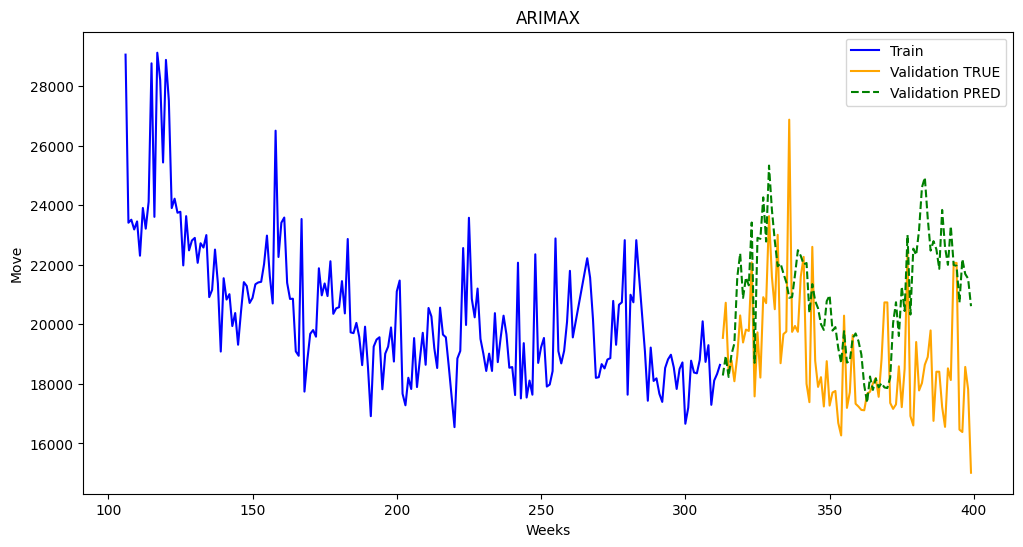

In [228]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_size = int(0.78 * len(data))
train = data.iloc[:train_size]
val = data.iloc[train_size:]

y_train = train['move']
X_train = train.drop(columns=['move'])

y_val = val['move']
X_val = val.drop(columns=['move'])

model = SARIMAX(y_train, exog=X_train, order=(5, 2, 13), seasonal_order=(0, 0, 0, 52))
results = model.fit(disp=False)

y_pred = results.predict(start=len(y_train), end=len(y_train) + len(y_val) - 1, exog=X_val)
y_pred = np.round(y_pred).astype(int)

plt.figure(figsize=(12, 6))
plt.plot(y_train.index[-200:], y_train.iloc[-200:], label='Train', color='blue')
plt.plot(y_val.index, y_val, label='Validation TRUE', color='orange')
plt.plot(y_val.index, y_pred, label='Validation PRED', color='green', linestyle='--')
plt.title('ARIMAX')
plt.xlabel('Weeks')
plt.ylabel('Move')
plt.legend()
plt.show()

In [230]:
print('baseline WMAPE', wmape(y_val, [np.mean(y_val)] * len(y_val)))
print('WMAPE', wmape(y_val, y_pred))

baseline WMAPE 8.044994425888296
WMAPE 12.502508004333832


Попробуем поменять параметры - количество лагов p и порядок rolling mean q - на 1.

In [231]:
model = SARIMAX(y_train, exog=X_train, order=(1, 2, 1), seasonal_order=(0, 0, 0, 52))
results = model.fit(disp=False)
y_pred = np.round(results.predict(start=len(y_train), end=len(y_train) + len(y_val) - 1, exog=X_val)).astype(int)
print('baseline WMAPE', wmape(y_val, [np.mean(y_val)] * len(y_val)))
print('WMAPE', wmape(y_val, y_pred))

baseline WMAPE 8.044994425888296
WMAPE 8.8267768526704


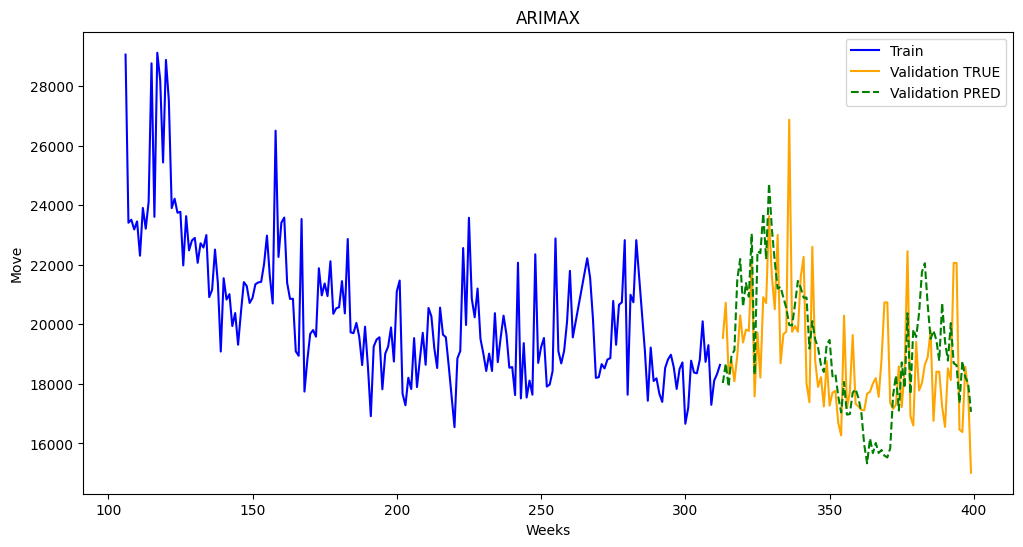

In [232]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index[-200:], y_train.iloc[-200:], label='Train', color='blue')
plt.plot(y_val.index, y_val, label='Validation TRUE', color='orange')
plt.plot(y_val.index, y_pred, label='Validation PRED', color='green', linestyle='--')
plt.title('ARIMAX')
plt.xlabel('Weeks')
plt.ylabel('Move')
plt.legend()
plt.show()

Метрика улучшилась, но она несколько хуже, чем у бейзлайна. После 350 недели видим явное занижение, а потом завышение значений. Согласно таблице из мануала, в этот период проходят праздники Memorial Day, 4th of July, Labor Day. Возможно, комбинации этих признаков вносят шум в данные. Проверим это:

In [109]:
import warnings
warnings.filterwarnings("ignore")

In [126]:
for cols in [['Memorial Day'], ['4th of July'], ['Labor Day'],
             ['Memorial Day', '4th of July'], 
             ['Memorial Day','Labor Day'],
             ['4th of July', 'Labor Day']]:

    y_train = train['move']
    X_train = train.drop(columns=(['move'] + cols))

    y_val = val['move']
    X_val = val.drop(columns=(['move'] + cols))

    model = SARIMAX(y_train, exog=X_train, order=(1, 2, 1), seasonal_order=(0, 0, 0, 52))
    results = model.fit(disp=False)

    y_pred = results.predict(start=len(y_train), end=len(y_train) + len(y_val) - 1, exog=X_val)

    print('removed', cols)
    print('baseline WMAPE', wmape(y_val, [np.mean(y_val)] * len(y_val)))
    print('WMAPE', wmape(y_val, y_pred))
    print()

removed ['Memorial Day']
baseline WMAPE 8.044994425888296
WMAPE 8.839837137902885

removed ['4th of July']
baseline WMAPE 8.044994425888296
WMAPE 8.832899324562735

removed ['Labor Day']
baseline WMAPE 8.044994425888296
WMAPE 8.840255432134631

removed ['Memorial Day', '4th of July']
baseline WMAPE 8.044994425888296
WMAPE 11.826847179190729

removed ['Memorial Day', 'Labor Day']
baseline WMAPE 8.044994425888296
WMAPE 8.862958797263971

removed ['4th of July', 'Labor Day']
baseline WMAPE 8.044994425888296
WMAPE 10.53980855181341



Лучше не стало, поэтому остановимся на полных данных. 

In [127]:
model = SARIMAX(y_train, exog=X_train, order=(1, 2, 1), seasonal_order=(0, 0, 0, 52))
results = model.fit(disp=False)
results.save("arimax_model_ana.pkl")

##### Cigarettes

In [233]:
data = preprocess(cig_data)

In [234]:
train_data, val_data = (
    data[0 : int(len(data) * 0.78)],
    data[int(len(data) * 0.78) :],
)

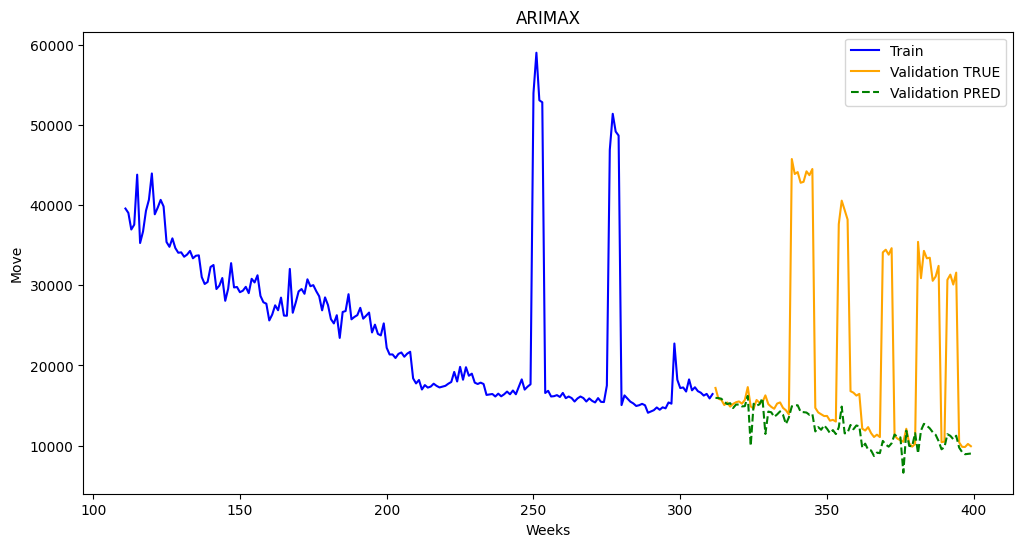

In [235]:
train_size = int(0.78 * len(data))
train = data.iloc[:train_size]
val = data.iloc[train_size:]

y_train = train['move']
X_train = train.drop(columns=['move'])

y_val = val['move']
X_val = val.drop(columns=['move'])

model = SARIMAX(y_train, exog=X_train, order=(5, 2, 13), seasonal_order=(0, 0, 0, 52))
results = model.fit(disp=False)

y_pred = np.round(results.predict(start=len(y_train), end=len(y_train) + len(y_val) - 1, exog=X_val)).astype(int)

plt.figure(figsize=(12, 6))
plt.plot(y_train.index[-200:], y_train.iloc[-200:], label='Train', color='blue')
plt.plot(y_val.index, y_val, label='Validation TRUE', color='orange')
plt.plot(y_val.index, y_pred, label='Validation PRED', color='green', linestyle='--')
plt.title('ARIMAX')
plt.xlabel('Weeks')
plt.ylabel('Move')
plt.legend()
plt.show()

Мы можем обрезать тренировочный датасет и взять только самые последние данные.

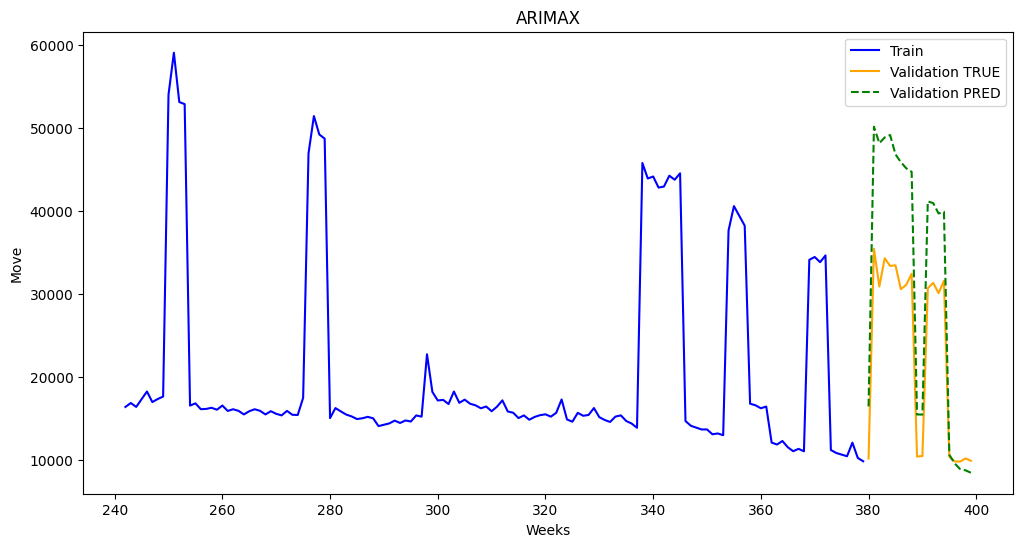

In [236]:
train_size = int(0.95 * len(data))
train = data.iloc[240:train_size]
val = data.iloc[train_size:]

y_train = train['move']
X_train = train.drop(columns=['move'])

y_val = val['move']
X_val = val.drop(columns=['move'])

model = SARIMAX(y_train, exog=X_train, order=(1, 2, 1), seasonal_order=(0, 0, 0, 26))
results = model.fit(disp=False)

y_pred = np.round(results.predict(start=len(y_train), end=len(y_train) + len(y_val) - 1, exog=X_val)).astype(int)

plt.figure(figsize=(12, 6))
plt.plot(y_train.index[-200:], y_train.iloc[-200:], label='Train', color='blue')
plt.plot(y_val.index, y_val, label='Validation TRUE', color='orange')
plt.plot(y_val.index, y_pred, label='Validation PRED', color='green', linestyle='--')
plt.title('ARIMAX')
plt.xlabel('Weeks')
plt.ylabel('Move')
plt.legend()
plt.show()

In [244]:
print('baseline WMAPE', wmape(y_val, [np.mean(y_val)] * len(y_val)))
print('WMAPE', wmape(y_val.values, y_pred.values))

baseline WMAPE 45.171785584156716
WMAPE 37.68116252652335
